In [1]:
from IPython.core.display import HTML
from string import Template
def jsConfig():
    src = """
    <script>require.config({ baseUrl: 'https://rawgit.com/kompgraf/course-material/master/assets/' });</script>
    """
    return HTML(src)
def addScript(script, identifier):
    src = Template("""
    <div id="${identifier}-container"></div>
    <script>require(['${script}'], main => main($$("#${identifier}-container"), '${identifier}'));</script>
    """)
    return HTML(src.substitute(script = script, identifier = identifier))
jsConfig()


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# B-Spline

## Bevezetés, avagy miért szükséges a B-Spline?

A megelőző jegyzetekben már számos különböző görbetípussal megismerkedtünk, melyek különböző paramétereket igényeltek, és igen eltérő tulajdonságokkal rendelkeztek. Miért van szükség egy újabb fajta görbére, melyek azok a problémák, melyek az eddig bemutatott görbékkel egyáltalán nem, vagy csak szuboptimális módon oldhatóak meg?

Az Hermite-ív előnytelen voltáról már a Bézier-görbével kapcsolatos jegyzetben is volt szó. Az, hogy ehhez a görbetípushoz explicit módon meg kell adnunk az érintővektorokat, kényelmetlenné teszi a használatát. Ráadásul a kontrollpontok számának növelése esetén magunknak kell gondoskodnunk a görbék csatlakoztatásáról.

A Cardinal Spline az Hermite-ív esetén tapasztalt problémákat megoldja, hiszen az érintővektorok előállítása automatikus, és a megfelelően definiált súlyfüggvények a görbedarabok csatlakozását is biztosítják. Ez az a pont azonban, ahol a Cardinal Spline legnagyobb gyengesége megjelenik. A görbét alkotó görbedarabok csatlakozása csupán $C^1$ folytonosságú, mely sok esetben nem elégséges. Számtalan esetben ennél magasabb rendű folytonosság szükséges.

Szerencsére rendelkezünk még egy görbetípussal a tarsolyunkban, a Bézier-görbével. Ez, akárcsak a Cardinal Spline, kizárólag a kontrollpontokat igényli, mint geometriai adat. Megoldja a csatlakozás problémáját is, hiszen tetszőleges számú kontrollpontra tudunk egy darabból álló Bézier-görbét illeszteni, azaz nem lesznek csatlakozási pontok. Mely tulajdonságok alkotják akkor a Bézier-görbe árnyoldalát? 

Az elhelyezett kontrollpontok számával egyenesen arányosan nő a Bézier-görbe fokszáma is. Például kilenc kontrollpontra már nyolcadfokú görbét fogunk illeszteni! A legtöbb alkalmazás nem igényel ilyen magas fokszámú görbét, emellett számítási instabilitások is megjelenhetnek. Nem szabad elfelejteni azt sem, hogy a Bézier-görbe csak pszeudoglobálisan változtatható. Azaz bármely kontrollpont elmozdítása hatással van a *teljes* görbére.

Mind a fokszám, mind a pszeudoglobális változtathatóság problémáját meg tudnánk oldani azzal, ha több Bézier-görbe darabot illesztenénk össze. Ez azonban nem más, mint a Cardinal-Spline, ráadásul manuálisan kellene biztosítanunk a megfelelő folytonosságú csatlakozást, ami rendkívül fáradságos.

Láthatjuk, hogy az eddig ismert görbetípusokkal nem tudunk tetszőleges folytonosságú csatlakozásokat és egyúttal lokális változtathatóságot biztosítani. A B-Spline görbe fog ebben a szorongatott helyzetben a segítségünkre sietni.

## A B-Spline súlyfüggvények

Most már tudjuk, hogy melyek azok a tulajdonságok, melyekkel az új görbetípusnak rendelkeznie kell. Tervezzük meg ezek alapján a B-Spline görbét! Ehhez először megfelelően megválasztott súlyfüggvényekre van szükség, hiszen a görbét ezúttal is a súlyfüggvények és a geometriai adatok kombinációjaként szeretnénk leírni, valamilyen paramétertartomány fölött értelmezve:

$$
\gamma(t) = \sum\limits_{i=0}^{n} b(t - i) \cdot P_i .
$$

Ha a fenti képletben szereplő, egyelőre nem definiált $b$ függvény jó tulajdonságokkal rendelkezik, akkor a görbe is örökölni fogja azokat:

  * Ha $b(t)$ az értelmezési tartománynak csak egy kis részén vesz fel nullától különböző értéket, akkor a $\gamma(t)$ függvényben szereplő összeg szintén csak néhány nullától különböző tagból fog állni. Ennek eredményeként bármely $t$ esetén csak korlátozott számú kontrollpont kombinációja adja az adott paraméterértékhez tartozó görbepontot.
  * Ha $b(t)$ olyan, hogy $\sum b(t-i) = 1$ teljesül bármely $t$ esetén, akkor a $\gamma(t)$ függvény nem más, mint a kontrollpontok affin kombinációja. Ez azt jelenti, hogy az előállított görbe az affin transzformációkra invariáns lesz.
  * Ha az előző tulajdonság mellett $b(t) \in [0, 1]$ bármilyen $t$ értékre, akkor a $\sum\limits_{i=0}^{n} b(t - i) \cdot P_i$ összeg a kontrollpontok konvex kombinációja. Ez garantálja, hogy a görbe a kontrollpontok konvex burkán belül fog haladni.
  
A lokális változtathatóság lehetőségét és a konvex burok tulajdonságot mindenképpen biztosítani szeretnénk. Mi szükséges viszont ahhoz, hogy magasabb, akár tetszőleges fokszámúak legyenek a csatlakozások? Természetesen magasabb fokszámú görbedarabok. Itt érdemes visszagondolni a Bézier-görbére, melynél az okozta a problémát, hogy a görbe fokszáma a kontrollpontok számával arányosan nőtt. Válasszuk tehát el egymástól a kettőt! Tegyük lehetővé, hogy az egyes darabok fokszáma a kontrollpontok számától függetlenül (de azok által meghatározott korlátok között) változtatható legyen!

### Csomók

Mind a Cardinal Spline-t, mind az előző $\gamma(t)$ függvényt úgy definiáltuk, hogy a görbe értelmezési tartományát $1$ hosszúságú részekre osztottuk. Hagyjuk el ezt a kötöttséget is, és osszuk fel a paramétertartományt tetszőleges, akár $0$ hosszúságú darabokra! Azaz az egyes görbedarabokhoz a paramétertartomány más és más hosszúságú részei fognak tartozni, újabb lehetőséget biztosítva a görbe alakjának módosítására.

Tegyük fel, hogy a $t$ paraméter $0$ és $1$ között vehet fel értékeket. Ekkor a $[0, 1]$ tartományt részekre osztó

$$
0 \leq t_0 \leq t_1 \leq \ldots \leq t_m \leq 1
$$

értékeket *csomóknak* nevezzük. A csomók egy monoton növekvő sorozatot alkotnak, azaz $t_i \leq t_{i + 1}$ bármely $i$ esetén. A csomók a paramétertartományt csomótartományoknak nevezett részekre osztják. Az $i$-edik csomótartomány a $[t_i, t_{i + 1})$ intervallum lesz. Mivel az egyenlőség megengedett, egy-egy intervallum akár $0$ hosszúságú is lehet. Ez akkor fordulhat elő, ha egy csomó többször is előfordul. Ha a $t_i$ csomó előfordulásainak száma $k$, akkor azt mondjuk, hogy $t_i$ egy $k$ multiplicitású csomó.

A csomókból egy vektor képezhető (jelölje ezt $U$), melyet *csomóvektornak* nevezünk. Azt mondjuk, hogy a csomóvektor *uniform*, amennyiben a csomótartományok hossza azonos, azaz az egymást követő csomók közti különbség állandó. Egyébként a csomóvektor *nem-uniform*.

A nem-uniform (azaz nem $1$ hosszúságú) csomótartományok megjelenése miatt a $b(t - i)$ kifejezés már nem lesz használható a görbét leíró függvényben. Helyette más módon kell megadnunk a súlyfüggvényt, súlyfüggvényeket. 

### Rekurzív definíció

A B-Spline súlyfüggvényeket egy rekurzív formula segítségével fogjuk megadni. Az $i$-edik $p$-edfokú B-Spline súlyfüggvényt $N_{i, p}(t)$-vel jelöljük, és a következőképpen definiáljuk:

$$
\begin{align*}
N_{i, 0}(t) &= 
  \begin{cases}
    1, & \text{ha } t_i \leq t < t_{i + 1} \\
    0, & \text{egyébként}
  \end{cases} \\
N_{i, p}(t) &= \frac{t - t_i}{t_{i + p} - t_i} \cdot N_{i, p - 1}(t) + \frac{t_{i + p + 1} - t}{t_{i + p + 1} - t_{i + 1}} \cdot N_{i + 1, p - 1}(t).
\end{align*}
$$

Bár a fenti definíció összetettnek tűnik, valójában rendkívül egyszerű. Ha $p$ értéke $0$, akkor a súlyfüggvény $1$-et vesz fel, ha $t$ benne van az $i$-edik csomótartományban, és $0$-t egyébként.

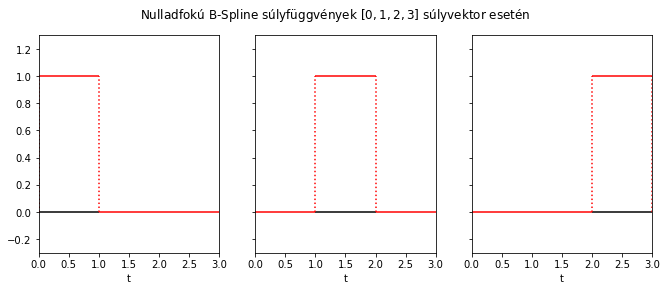

In [73]:
def n0(i, axes):    
    axes.set_ylim([-0.3, 1.3])
    axes.set_xlim([0, 3])

    axes.hlines(0, xmin=i, xmax=i+1, color='k')
    
    axes.hlines(1, xmin=i, xmax=i+1, color="r")
    axes.hlines(0, xmin=0, xmax=i, color="r")
    axes.hlines(0, xmin=i+1, xmax=3, color="r")
    
    axes.vlines(i, ymin=0, ymax=1, color="r", linestyle=":")
    axes.vlines(i+1, ymin=0, ymax=1, color="r", linestyle=":")
    
    axes.set_xlabel('t')


def showCardinalSplineBlendingFunctions():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (11, 4))
    
    plt.suptitle("Nulladfokú B-Spline súlyfüggvények $[0, 1, 2, 3]$ súlyvektor esetén")
    
    n0(0, ax1)
    n0(1, ax2)
    n0(2, ax3)
    
showCardinalSplineBlendingFunctions()

A magasabb fokszámú definíció pedig két alacsonyabb fokszámú súlyfüggvény kombinációjaként áll elő.

A számítás menetét egy háromszöghöz hasonló sémával illusztrálhatjuk.

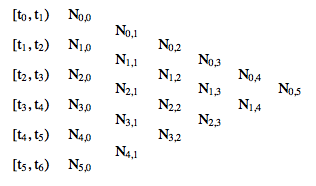

A háromszög legalján (az ábrán a második oszlop) a rekurzió alapesetei, a nulladfokú súlyfüggvények szerepelnek. Adott $t$ esetén ezek értékét rögtön ki tudjuk számolni. Ezután léphetünk feljebb a háromszögben. $N_{i, 1}(t)$ meghatározásához szükség van két nulladfokú súlyfüggvény értékére, melyeket előzőleg számoltunk ki. Ezeket a súlyfüggvény definíciójának megfelelően kombináljuk, majd pedig feljebb lépünk a következő szintre. Ezt addig ismételjük, amíg az adott $t$ és $p$ értékekre az összes $N_{i, p}(t)$ érték előállt.

Legyen például a súlyvektorunk $U = [0, 1, 2, 3, 4]$! Ábrázoljuk az $N_{i, 1}(t)$ függvényeket!

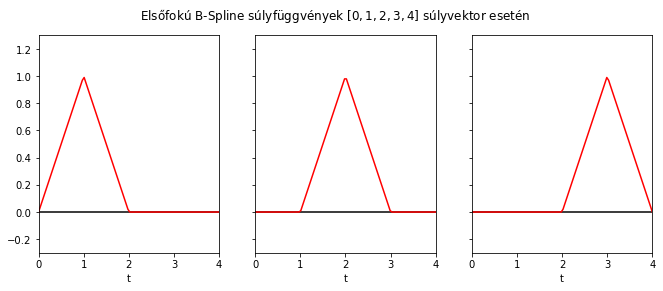

In [99]:
def n1(i, axes):   
    u = [0, 1, 2, 3, 4]
    t = np.linspace(0, 4, 100)
    
    n0 = lambda i, t: (t >= u[i]) * (t < u[i + 1]) * 1
    
    f = (t - u[i]) / (u[i + 1] - u[i]) * n0(i, t) + (u[i + 2] - t)/(u[i + 2] - u[i + 1]) * n0(i + 1, t)
    
    axes.set_ylim([-0.3, 1.3])
    axes.set_xlim([0, 4])

    axes.axhline(y=0, color='k')
    axes.plot(t, f, 'r', label='$h_0$')
    
    axes.set_xlabel('t')


def showCardinalSplineBlendingFunctions():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (11, 4))
    
    plt.suptitle("Elsőfokú B-Spline súlyfüggvények $[0, 1, 2, 3, 4]$ súlyvektor esetén")
    
    n1(0, ax1)
    n1(1, ax2)
    n1(2, ax3)

    
showCardinalSplineBlendingFunctions()

Vegyük észre, hogy az elsőfokú súlyfüggvények már két csomótartományon is nullától különböző értéket vesznek fel! Tehát a függvényábrák összhangban vannak az előbb felírt háromszöggel. Minél feljebb haladunk, annál több csomótartományra támaszkodik egy adott súlyfüggvény, ami azt jelenti, hogy a paramétertartománynak egy nagyobb részén fog nullától különböző értéket felvenni. Fogalmazzuk meg ezt az összefüggést részletesebben!

### A súlyfüggvények és a csomótartományok kapcsolata

Az előbb felírt háromszög-séma alapján vizsgáljuk meg, hogy milyen kapcsolatban vannak egymással a súlyfüggvények és a csomótartományok!

Ahogy már arról szó volt, minden $N_{i, 1}(t)$ értéket két nulladfokú súlyfüggvényérték, $N_{i, 0}(t)$ és $N_{i + 1, 0}(t)$ alapján határozhatunk meg. Mivel az említett két súlyfüggvény a $[t_i, t_{i+1})$ és a $[t_{i + 1}, t_{i+2})$ csomótartományokon vesz csak fel nullától különböző értéket, ezért $N_{i, 1}(t)$ is e két tartományon lesz nullától különböző.

Ha eggyel feljebb lépünk, hasonlót figyelhetünk meg $N_{i, 2}(t)$ esetén is, mely két elsőfokú súlyfüggvénytől, $N_{i, 1}(t)$-től és $N_{i + 1, 1}(t)$-től függ. Ezek két-két nulladfokú súlyfüggvényre támaszkodnak, melyek közül kettő azonban azonos, így három különböző marad. Ennek következében a másodfokú súlyfüggvények három csomótartományon vesznek fel nullától különböző értéket.

Megfigyelésünket a következőképpen foglalhatjuk össze:

> Az $N_{i, p}(t)$ súlyfüggvény $p + 1$ darab szomszédos csomótartományon vesz fel nullától különböző értéket, melyek együttesen a  $[t_i, t_{i + p + 1})$ intervallumnak felelnek meg.

Fordítva, a csomótartományok szempontjából is megfogalmazhatunk egy hasonló kijelentést:

> A $[t_i, t_{i + 1})$ csomótartományon legfeljebb $p + 1$ $p$-edfokú súlyfüggvény vesz fel nullától különböző értéket, melyek az $N_{i - p, p}(t), N_{i - p + 1, p}(t), \ldots, N_{i, p}(t)$ súlyfüggvények.

### A súlyfüggvények együtthatói

Az előző megfigyelések ismeretében már könnyedén megfejthetjük, hogy mi a jelentése a magasabb fokú esetet leíró ágban az együtthatóknak. Emékeztetőül álljon itt $p > 0$ esetén $N_{i, p}(t)$ definíciója:

$$
N_{i, p}(t) = \frac{t - t_i}{t_{i + p} - t_i} \cdot N_{i, p - 1}(t) + \frac{t_{i + p + 1} - t}{t_{i + p + 1} - t_{i + 1}} \cdot N_{i + 1, p - 1}(t).
$$

Ez a definíció két alacsonyabb fokú függvényre, $N_{i, p-1}(t)$-re és $N_{i + 1, p - 1}(t)$-re támaszkodik. Az előbbi a $[t_i, t_{i + p})$ tartományon lesz nullától különböző. Tehát a $\frac{t - t_i}{t_{i + p} - t_i}$ tört nevezője ennek a tartománynak a hossza. Ha $t$ az előbb említett intervallumon belül van, akkor a számláló nem lesz más, mint $t$ távolsága az intervallum bal szélétől. 

Hasonlóan írhatjuk le a másik együtthatót is. Tudjuk, hogy $N_{i + 1, p - 1}(t)$ nullától különböző értékkel rendelkezik a $[t_{i + 1}, t_{i + p + 1})$ intervallumon. Az együttható nevezője ennek az intervallumnak a hossza. Ha $t$ benne van ebben a tartományban, akkor a számláló $t$ távolsága az intervallum jobb szélétől.

## B-Spline görbe

A súlyfüggvények áttekintése után írjuk fel a B-Spline görbe definícióját! Legyenek adottak a $P_0, P_1, \ldots, P_{n}$ kontrollpontok, a görbe $1 \leq p \leq n$ foka és az $U = [t_0, t_1, \ldots, t_{n + p + 1}]$ csomóvektor! Azaz a kontrollpontok száma $n + 1$, a csomóké pedig $n + p + 2$. Az ezen adatok által meghatározott B-Spline görbe a következő:

$$
b(t) = \sum\limits_{i = 0}^{n} N_{i, p}(t) \cdot P_i \qquad t \in [t_p, t_{n + 1}]
$$

Ez lesz az úgynevezett NUBS, azaz **N**em-**U**niform **B**-**S**pline görbe definíciója. Ennek speciális esete (ha $U$ uniform) az Uniform B-Spline görbe.

### A paramétertartomány

A függvény definíciójában szerepel, hogy $t \in [t_p, t_{n + 1}]$, ami felveti a kérdést, hogy miért nem fut végig $t$ az első és az utolsó csomó közötti teljes intervallumon?

Már felírtuk, hogy egy csomótartományon legfeljebb $p + 1$ darab $p$-edfokú súlyfüggvény lehet nullától különböző. A görbepontok számítása során csak azokat a csomótartományokat vesszük figyelembe, melyek fölött a maximális számú, $p + 1$ darab $p$-edfokú súlyfüggvény tér el nullától. 

Az első ilyen tartomány a $[t_{p}, t_{p + 1})$, mivel efölött az $N_{p - p, p}(t), \ldots, N_{p, p}(t)$ függvények lesz nullától különbözőek, ahol $N_{0, p}(t)$ nem más, mint az első kontrollponthoz tartozó $p$-edfokú súlyfüggvény. Az utolsó, a feltételnek eleget tevő csomótartomány pedig a $[t_n, t_{n + 1})$, hiszen ezen az $N_{n - p, p}(t), \ldots, N_{n, p}(t)$ függvények bírnak nullától eltérő értékkel, ahol $N_{n, p}(t)$ az utolsó kontrollponthoz tartozó súlyfüggvény.

### Demonstráció

A következő demonstráció a NUBS görbe tanulmányozására ad lehetőséget. A kék téglalapba kattintva helyezhetük el új kontrollpontokat, melyeket aztán vonszolással helyezhetünk át. A görbe kirajzolásához legalább három darab kontrollpontot kell elhelyezni. A csomók és a fokszám módosítását lehetővé tevő mezők csak ezután fognak megjelenni.

In [3]:
addScript("js/nubs-demo", "nubs-demo")

### A végpontok interpolációja

Az első és az utolsó kontrollpontok érintését megfelelő csomók segítségével tudjuk elérni. Legyen a görbe fokszáma $p$, kontrollpontjainak száma $n + 1$! Ekkor $n + p + 2$ darab csomóval rendelkezünk. Ahhoz, hogy a görbe érintse az első kontrollpontot, az első csomónak $p + 1$ multiplicitással kell rendelkeznie, azaz $t_0 = t_1 = \ldots = t_{p}$.

Ekkor $P_0$ kontrollponthoz tartozó $p$-edfokú súlyfüggvény $N_{0, p}(t)$. Ez $p + 1$ csomótartományon lesz nullától különböző, mely a $[t_0, t_{p + 1})$ intervallum. Mivel $t_0 = t_1 = \ldots = t_p$, ezért az ezen csomók által meghatározott csomótartományok eltűnnek, azt eredményezve, hogy az $N_{0, 0}(t), N_{1, 0}(t), \ldots, N_{p - 1, 0}(t)$ súlyfüggvények mindig nullát fognak felvenni, bármely $t$-re. Csak $N_{p, 0}(t)$ lesz nullától különböző (azaz $1$), aminek köszönhetően $b(t_p) = P_0$. 

Az utolsó kontrollpont érintése is hasonlóan vezethető le, melyhez $p + 1$ multiplicitású utolsó csomó szükséges.

Mindenképpen próbáljuk ki a csomóvektor ilyen összeállítását a demonstrációban is!

### Tulajdonságok

Legyen a görbe fokszáma $p$, kontrollpontjainak száma $n + 1$! Ekkor a B-Spline görbe a következő tulajdonságokkal rendelkezik.

* A $b(t)$ függvény által leírt görbe $p$-edfokú szegmensekből épül fel. Minél magasabb a fokszám, annál távolabb kerül a görbe a kontrollpoligontól, míg $p = 1$ esetén a görbe a kontrollpontokat összekötő töröttvonallal esik egybe.
* A görbe adott $t$ esetén, ha $t \in [t_i, t_{i + 1})$, akkor a $P_{i - p}, P_{i - p + 1}, \ldots, P_{i}$ kontrollpontok konvex burkában halad. Ez erősebb, mint az egyszerű konvex burok tulajdonság, amit például a Bézier-görbe esetén láttunk.
* A görbe az affin transzformációkra invariáns. Ez következik abból, hogy $b(t)$ a kontrollpontok affin kombinációja.
* A görbe lokálisan változtatható, azaz a $P_i$ kontrollpont elmozdítása csak a $[t_i, t_{i + p + 1})$ tartományon változtatja meg a görbe alakját. Ez következik abból, hogy a $P_i$-hez tartozó $N_{i, p}$ súlyfüggvény csak ezen az intervallumon vesz fel nullától különböző értéket. Ha $t$ ezen a tartományon kívül esik, akkor $N_{i, p}(t)=0$.
* $b(t)$ egy $k$ multiplicitású csomóban $C^{p - k}$ folytonos.

Érdemes ismét visszatérni a demonstrációhoz, és megvizsgálni a leírt tulajdonságokat!

### Mátrix alak

Írjuk fel a harmadfokú, uniform B-Spline görbe mátrix alakját! Ekkor tehát $p = 3$ és adott $n + 1 \geq 4$ kontrollpont. A csomók legyenek oly módon adottak, hogy $t_i = i$.

Ekkor a görbét leíró függvény

$$
b(t) = \sum\limits_{i = 0}^{n} N_{i, 3}(t) \cdot P_i.
$$

Mivel a csomóvektor uniform, ezért az egyes $N_{i, 3}(t)$ függvények mindegyike az $N_{0, 3}(t)$ függvény eltoltja lesz. Emiatt elég az $N_{0, 3}(t)$ súlyfüggvény leírnunk. A görbe definíciója ennek ismeretében a következő formára egyszerűsödik:

$$
b(t) = \sum\limits_{i = 0}^{n} N_{0, 3}(t - i) \cdot P_i
$$

Írjuk fel az összes olyan súlyfüggvényt, melyre $N_{0, 3}(t)$ támaszkodik!

#### Nulladfokú súlyfüggvények

$$
\begin{align*}
N_{0, 0}(t) &= 
  \begin{cases}
    1, & \text{ha } 0 \leq t < 1 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{1, 0}(t) &= 
  \begin{cases}
    1, & \text{ha } 1 \leq t < 2 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{2, 0}(t) &= 
  \begin{cases}
    1, & \text{ha } 2 \leq t < 3 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{3, 0}(t) &= 
  \begin{cases}
    1, & \text{ha } 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases}
\end{align*}
$$

#### Elsőfokú súlyfüggvények

Az elsőfokú súlyfüggvényeket a következőképpen írhatjuk fel:

$$
\begin{align*}
N_{0, 1}(t) &= t \cdot N_{0, 0}(t) + (2 - t) \cdot N_{1, 0}(t) \\
N_{1, 1}(t) &= (t - 1) \cdot N_{1, 0}(t) + (3 - t) \cdot N_{2, 0}(t) \\
N_{2, 1}(t) &= (t - 2) \cdot N_{2, 0}(t) + (4 - t) \cdot N_{3, 0}(t)
\end{align*}
$$

Felhasználva a nulladfokú súlyfüggvényeket, írjuk fel az elsőfokúakat is szakaszosan definiált formában:

$$
\begin{align*}
N_{0, 1}(t) &= 
  \begin{cases}
    t, & 0 \leq t < 1 \\
    2 - t, & 1 \leq t < 2 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{1, 1}(t) &= 
  \begin{cases}
    t - 1, & 1 \leq t < 2 \\
    3 - t, & 2 \leq t < 3 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{2, 1}(t) &= 
  \begin{cases}
    t - 2, & 2 \leq t < 3 \\
    4 - t, & 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases}
\end{align*}
$$

#### Másodfokú súlyfüggvények

Folytassuk a sort a másodfokú súlyfüggvényekkel, először a hagyományos definíciót, majd a szakaszosan definiált formát alkalmazva:

$$
\begin{align*}
N_{0, 2}(t) &= \frac{t}{2} \cdot N_{0, 1}(t) + \frac{3 - t}{2} \cdot N_{1, 1}(t) \\
N_{1, 2}(t) &= \frac{t - 1}{2} \cdot N_{1, 1}(t) + \frac{4 - t}{2} \cdot N_{2, 1}(t)
\end{align*}
$$

$$
\begin{align*}
N_{0, 2}(t) &= 
  \begin{cases}
    \frac{t^2}{2}, & 0 \leq t < 1 \\
    \frac{t \cdot (2 - t)}{2} + \frac{(3 - t)(t - 1)}{2}, & 1 \leq t < 2 \\
    \frac{(3 - t)^2}{2}, & 2 \leq t < 3 \\
    0, & \text{egyébként}
  \end{cases} \\
N_{1, 2}(t) &= 
  \begin{cases}
    \frac{(t - 1)^2}{2}, & 1 \leq t < 2 \\
    \frac{(t - 1) \cdot (3 - t)}{2} + \frac{(4 - t)(t - 2)}{2}, & 2 \leq t < 3 \\
    \frac{(4 - t)^2}{2}, & 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases}
\end{align*}
$$

#### A harmadfokú súlyfüggvény

A szakaszosan definiált forma előtt írjuk fel az $N_{0, 3}(t)$ függvényt is a definíció szerinti alakjában:

$$
N_{0, 3}(t) = \frac{t}{3} \cdot N_{0, 2}(t) + \frac{4 - t}{3} \cdot N_{1, 2}(t).
$$

Az alacsonyabb fokú súlyfüggvények és azok intervallumai segítségével most már könnyedén felírhatjuk az $N_{0, 3}(t)$ szakaszosan definiált formáját:

$$
N_{0, 3}(t)=
\begin{cases}
    \frac{1}{6}t^3, & 0 \leq t < 1 \\
    \frac{1}{6}(-3t^3 + 12t^2 -12t + 4), & 1 \leq t < 2 \\
    \frac{1}{6}(3t^3-24t^2+60t-44), & 2 \leq t < 3 \\
    \frac{1}{6}(-t^3 +12t^2-48t +64), & 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases} \\
$$

#### Mátrix alakú egyenlet

Mivel a görbénk harmadfokú, ezért minden szegmenst négy kontrollpont fog meghatározni. Az $i$-edik szegmenst tehát a $P_i, P_{i + 1}, P_{i + 2}, P_{i + 3}$ pontok fogják befolyásolni. Jelölje $G_i$ az ezekből a kontrollpontokból képzett mátrixot.

A $t$ paraméterből képzett mátrixot jelölje $T(t)$, és legyen a következő formában adott:

$$
T(t) =
\begin{bmatrix}
t^3 \\
t^2 \\
t \\
1
\end{bmatrix}
$$

Ekkor az $i$-edik szegmenst a következő függvény segítségével írhatjuk le:

$$
\gamma_i(t) = G_iMT(t) \qquad t \in [0, 1]
$$

Ahol $M$ az egyelőre még ismeretlen együtthatómátrix. Vegyük észre, hogy ez a függvény a $[0, 1]$ intervallum fölött van definiálva, viszont az előző $N_{0, 3}$ függvény $[0, 4]$ fölött. Emiatt át kell írnunk az $N_{0, 3}$ súlyfüggvényt, hogy az egyes pontokra egyidejűleg különböző ágait tudjuk alkalmazni, de mindenhova $[0, 1]$ tartománybeli $t$ értékeket írva, ahogy az a $GMT(t)$ formulában is szerepel! Ekkor

$$
N_{0, 3}(t)= \frac{1}{6}
\begin{cases}
    t^3, & 0 \leq t < 1 \\
    -3t^3 + 12t^2 -12t + 4, & 1 \leq t < 2 \\
    3t^3-24t^2+60t-44, & 2 \leq t < 3 \\
    -t^3 +12t^2-48t +64, & 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases}
= \frac{1}{6}
\begin{cases}
    t^3, & 0 \leq t < 1 \\
    -3(t - 1)^3 + 3(t - 1)^2 +3(t - 1) + 1, & 1 \leq t < 2 \\
    3(t-2)^3-6(t-2)^2+4, & 2 \leq t < 3 \\
    -(t - 3)^3+3(t - 3)^2-3(t -3) +1, & 3 \leq t < 4 \\
    0, & \text{egyébként}
  \end{cases}
$$

Ezután már nem $t$ együtthatóiból, hanem a $(t - x)$ kifejezések együtthatóiból fog felépülni a mátrix:

$$
M = \frac{1}{6}
\begin{bmatrix}
-1 & 3 & -3 & 1 \\
3 & -6 & 0 & 4 \\
-3 & 3 & 3 & 1 \\
1 & 0 & 0 & 0 \\
\end{bmatrix}
$$

E módon gyakorlatilag négy darab súlyfüggvényt kapunk, melyek az egyes szegmensek megfelelő pontjaihoz tartoznak. Ábrázoljuk ezeket a súlyfüggvényeket!

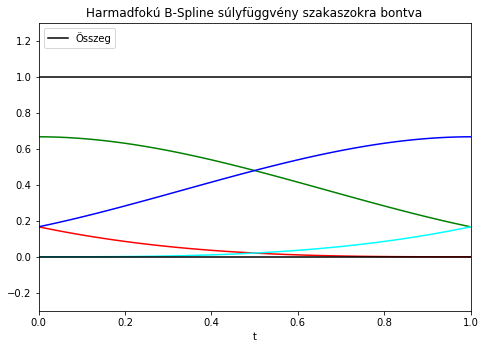

In [9]:
def thirdDegreeBSpline():
    t = np.linspace(0, 1, 100)

    b0 = (1/6) *((-1*(t**3)) +  (3 * (t**2)) + (-3 * t) + 1)
    b1 = (1/6) *((3*(t**3)) + (-6 * (t**2)) +  4)
    b2 = (1/6) * ((-3*(t**3)) +  (3 * (t**2)) + (3 * t) + 1)
    b3 = (1/6) * (t**3)

    fig = plt.figure()

    axes = fig.add_axes([0, 0, 1, 1])

    axes.set_xlim([0, 1])
    axes.set_ylim([-0.3, 1.3])

    axes.plot(t, b0, 'r')
    axes.plot(t, b1, 'g')
    axes.plot(t, b2, 'b')
    axes.plot(t, b3, 'cyan')
    axes.plot(t, b0 + b1 + b2 + b3, 'k', label='Összeg')
    
    axes.axhline(y=0, color='k')
    
    axes.legend(loc=2);

    axes.set_xlabel('t')
    axes.set_title('Harmadfokú B-Spline súlyfüggvény szakaszokra bontva');


thirdDegreeBSpline()

A teljes görbét úgy tudjuk kirajzolni, hogy négyesével vesszük a kontrollpontokat, ezzel $G$ mátrixot képezve belőlük. Ezután az így kapott mátrixot behelyettesítjük a $\gamma(t)$ függvénybe, és a $t$ paramétert $0$ és $1$ között végigfuttatjuk. $n + 1$ darab pont esetén ezt összesen $n - 2$ alkalommal megismételve előáll a teljes görbe.

#### Demonstráció

A demonstráció az előbb levezett mátrix alak segítségével képzett B-Spline görbét mutatja be. A kék téglalapba kattintva helyezhetünk el kontrollpontokat, melyeket vonszolással helyezhetünk át. A görbe kirajzolásához legalább $4$ kontrollpontot kell elhelyezni.

In [4]:
addScript("js/third-degree-b-spline-demo", "third-degree-b-spline-demo")

## Racionális B-Spline görbe

Eddig csupa polinomiális görbetípussal foglalkoztunk, melyek egyre jobb és jobb tulajdonságokkal bírtak. Azonban akárhogyan próbálkozunk, ezek nem képesek bizonyos görbék pontos leírására. Például a NUBS segítségével nem tudunk pontosan kört vagy ellipszist leírni.

A probléma megoldását a racionális görbék jelentik, a B-Spline racionális változatát NURBS-nek, azaz **N**em-**U**niform **R**acionális **B**-**S**pline görbének nevezik.

### Súlyok

A NURBS görbéhez újabb nem-geometriai paraméterekre, úgynevezett súlyokra van szükség. Minden kontrollpont rendelkezni fog egy súllyal, mely nullánál nagyobb értéket kell, hogy felvegyen. Az $i$-edik kontrollpont súlyát $w_i$-vel fogjuk jelölni.

A súlyoknak nem az abszolút értéke a fontos, hanem az egymáshoz viszonyított aránya. Ha az összes kontrollpont súlya $10$, akkor ugyanazt a görbét kapjuk, mint ha mindegyiknek a súlya $0{,}1$ lenne. 

Minél nagyobb súllyal rendelkezik egy kontrollpont a többihez képest, annál inkább hatással lesz a görbe alakjára; a görbe annál jobban megközelíti az adott pontot.

### Definíció

Legyenek adottak a $P_0, P_1, \ldots, P_{n}$ kontrollpontok, a $w_0, w_1, \ldots, w_n$ súlyok, a görbe $p$ foka, és az $U$ csomóvektor. Ekkor a NURBS görbét a következő függvény írja le:

$$
Q(t) = \sum_{i=0}^{n}R_{i, p}(t)P_i \qquad t \in \lbrack t_p, t_{n + 1} \rbrack,
$$

ahol $R_{i, p}$ az $i$-edik $p$-edfokú NURBS súlyfüggvény:

$$
R_{i, p}(t) = \frac{N_{i, p}(t) \cdot w_i}{\sum\limits_{j = 0}^{n}N_{j, p}(t) \cdot w_j}.
$$

Tehát a NURBS annyiban különbözik a NUBS görbétől, hogy a kontrollpontok kombinációjának súlyozott átlagát vesszük.

### Demonstráció

A demonstráció a NURBS görbét szemlélteti. Kattintással helyezhetőek el új kontrollpontok, és vonszolással helyezhetőek át a meglevőek. A görbe kirajzolásához legalább három darab kontrollpontot kell elhelyezni. A csomóértékek és a fokszám módosítását lehetővé tevő mezők csak ezután fognak megjelenni. Ha az egérmutató egy kontrollpont fölött van, akkor az adott kontrollponthoz tartozó súlyt az egérgörgő segítségével módosíthatjuk.

In [5]:
addScript("js/nurbs-homework", "nurbs-homework")

## Források

* C.-K. Shene (2014). *CS3621 Introduction to Computing with Geometry Notes* https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/
* J. F. Hughes, A. van Dam (2013). *Computer Graphics: Principles and Practice*, Third Edition, Chapter 22W, pp. 100-122. http://dept.cs.williams.edu/~morgan/cgpp/file/cgpp3e_ch22W.pdf
* Dr. Kovács Emőd (2011). *Komputergrafika: Matematikai alapok*. pp. 94-102. http://aries.ektf.hu/~hz/pdf-tamop/pdf-01/download/grafika.pdf

In [6]:
def styling():
    styles = open("../../styles/custom.html", "r").read()
    return HTML(styles)
styling()
